In [2]:
import numpy as np
import pysindy as ps
import h5py
from tqdm import trange
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import func_timeout
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
warnings.filterwarnings("ignore", category=UserWarning)

### Load in data and preprocess

In [2]:
n_data = 3000
d = h5py.File("data\\ref_data_train.jld", "r")
ref_data = d['ref_data_train'][:]
ref_params = d['ref_params_train'][:]
t = d['times_train'][:]
times = t.copy()
dt = 60

In [3]:
ref_param = np.empty((len(ref_params), 9))
for i in range(len(ref_params)):
    for j in range(9):
        ref_param[i,j] = ref_params[i][j]
ref_params = ref_param

In [4]:
EO = 4
ref_data[:,:,5] = EO * ref_data[:,:,5]

### PCA

In [5]:
# Importing standardscalar module 
from sklearn.preprocessing import StandardScaler
  
scalar = StandardScaler(with_std=False)
reshaped_data = np.concatenate([ref_data[i] for i in range(ref_data.shape[0])])
# fitting
scalar.fit(reshaped_data)
scaled_data = scalar.transform(reshaped_data)



# Importing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca = [pca.transform(scaled_data[i*48: i*48+48, :]) for i in range(ref_data.shape[0])]
x = np.concatenate(x_pca)

In [6]:
sum(pca.explained_variance_ratio_)

0.999794743101411

In [7]:
data = x_pca

### Construct libraries for E-SINDy

In [8]:
### define function for hv and emission along time
def hv_func(hv_shift, t):
    hv_1 = max(np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2), 0)
    hv_2 = max((np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2)+1.0)/2, 0)
    return np.array([hv_1 * 0.9 + hv_2 * 0.1])

def emission_func(const, init_shift, t):
    return 0.95*const + 0.05*const*np.sin((t +1500) /(1440/2)*np.pi - init_shift)

In [9]:
depositions =     np.array([-0.4/(100*12) * 60, 
    -4/(100*15)* 60,
    -0.5/(100*2) * 60,
    -0.1/(100*2) * 60,
    -0.03/2 * 60,
    -0.1/100 * 60]).reshape(1,6)

In [10]:
# Combine control variables with data
multi_U = []
for i in range(n_data):
    p = np.repeat(ref_params[i,0], t.shape[0])
    T = np.repeat(ref_params[i,1], t.shape[0])
    Tp =p*T
    depo = np.repeat(depositions, t.shape[0], axis=0)
    hv = np.concatenate([hv_func( ref_params[i,-1], ti) for ti in t-1500])
    emission1 = 0.0005 * np.stack([emission_func( ref_params[i,2], ref_params[i,5], ti) for ti in t-1500])
    emission2 = 0.0001 * np.stack([emission_func( ref_params[i,3],  ref_params[i,6], ti) for ti in t-1500])
    emission3 = 0.0008 * np.stack([emission_func( ref_params[i,4],  ref_params[i,7], ti) for ti in t-1500])
    multi_U.append(np.hstack((emission1.reshape(-1,1), emission2.reshape(-1,1), emission3.reshape(-1,1), depo, hv.reshape(-1,1), Tp.reshape(-1,1))))

# Custome library for U
poly_library = ps.PolynomialLibrary(degree=4, include_bias=False)
library_functions = [lambda x: x]
library_function_names = [
    lambda x: x
]

# lib for emissions
custom_library1 = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

# lib for other parameters
custom_library2 = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

inputs_temp = np.tile([i for i in range(14)], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 14))
inputs_per_library[0, 3:] = 2
inputs_per_library[1, :3] = 3
inputs_per_library[1, 12:] = 11
inputs_per_library[2, :12] = 12
print(inputs_per_library)

tensor_array = [[1, 0, 1]]

generalized_library = ps.GeneralizedLibrary(
    [poly_library, custom_library1, custom_library2],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

feature_names = ["pc1", "pc2", "pc3", "emission_NO2", "emission_HCHO", "emission_H2O2", "depo1","depo2","depo3","depo4", "depo5", "depo6", "hv", "p*T"]
optimizer = ps.STLSQ(threshold=1e-5)
u = np.concatenate(multi_U)
model = ps.SINDy()
dx= np.concatenate(model.differentiate(data, t=dt, multiple_trajectories=True))
generalized_library.fit(np.hstack((x, u)))
lib = generalized_library.transform(np.hstack((x, u)))

[[ 0  1  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  4  5  6  7  8  9 10 11 11 11]
 [12 12 12 12 12 12 12 12 12 12 12 12 12 13]]


### Training ensemble model with bootstrapping

In [11]:
ensemble = True
lib_ensemble = True
n_features = lib.shape[1]
COEF_THRESHOLD = 1e-14
n_models = 100
import random
random.seed(42)
np.random.seed(42)
res = []
per = 0.3
n_candidates_to_drop = 30
print((per, n_candidates_to_drop))
print("training model....")
n_subset = int(per * n_data * 48)
ensemble_coef = []
for i in trange(n_models):
    coef = np.zeros((3, n_features))
    if ensemble:
        rand_inds = np.random.choice(range(n_data * 48), n_subset, replace=False)
        lib_new = np.take(lib, rand_inds, axis=0)
        dx_new = np.take(dx, rand_inds, axis=0)
    else:
        lib_new = lib
        dx_new = dx
    if lib_ensemble:
        keep_inds = np.sort(np.random.choice(range(n_features), n_features - n_candidates_to_drop, replace=False))
        lib_new = lib_new.take(keep_inds, axis=1)
    else:
        keep_inds = range(n_features)

    optimizer.fit(lib_new, dx_new)
    coef[:, keep_inds] = optimizer.coef_
    ind_ = np.abs(coef) > COEF_THRESHOLD
    coef__ = np.zeros(coef.shape)
    for i in range(ind_.shape[0]):
        if np.any(ind_[i]):
            coef__[i, ind_[i]] = (LinearRegression(fit_intercept=False).fit(lib[:, ind_[i]], dx[:, i]).coef_)
    ensemble_coef.append(coef__)

(0.3, 30)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


### Prepare validation data and helper functions benchmark

In [12]:
from numbalsoda import lsoda_sig, lsoda, dop853
import numba as nb

In [13]:
def calc_rmse(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        reference[:,:,5] =  reference[:,:,5] / EO
        prediction[:,:,5] =  prediction[:,:,5] / EO
    else:
        reference[:,5] =  reference[:,5] / EO
        prediction[:,5] =  prediction[:,5] / EO
    return np.sqrt(np.mean((prediction - reference)**2))

def calc_rmse_O3(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        r =  reference[:,:,5] / EO
        p =  prediction[:,:,5] / EO
    else:
        r =  reference[:,5] / EO
        p =  prediction[:,5] / EO
    return np.sqrt(np.mean((p - r)**2))
def inv_transform(x):
    return scalar.inverse_transform(pca.inverse_transform(x))

In [14]:
d_validate = h5py.File("data\\ref_data_validate.jld", "r")
ref_params_validate = d_validate['ref_params_validate'][:]
ref_data_validate = d_validate['ref_data_validate'][:]
times_validate = d_validate['times_validate'][:]
ref_param = np.empty((len(ref_params_validate), 9))
for i in range(len(ref_params_validate)):
    for j in range(9):
        ref_param[i,j] = ref_params_validate[i][j]
ref_params_validate = ref_param
ref_data_validate[:,:,5] = EO * ref_data_validate[:,:,5]
multi_U_validate1 = []
    
for i in range(ref_params_validate.shape[0]):
    pT = ref_params_validate[i][0]* ref_params_validate[i][1]
    multi_U_validate1.append(np.concatenate((ref_params_validate[i][2:8], [pT], [ref_params_validate[i][-1]]), axis = 0))
reshaped_data_validate = np.concatenate([ref_data_validate[i] for i in range(ref_data_validate.shape[0])])
scaled_data_validate = scalar.transform(reshaped_data_validate)
validate_pca = [pca.transform(scaled_data_validate[i*24*9: i*24*9+24*9, :]) for i in range(375)]

In [15]:
times_validate-=1500

In [16]:
def r2_s(y_true, y_pred):
    sst = sum((y_true-np.mean(y_true))**2)
    ssr = sum((y_true-y_pred)**2)
    return 1-ssr/sst

### Tuning buffer term coefficients on validation dataset

In [17]:
coefs = [0, 1e-9,1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
res = []
for coef in coefs:
    ## define function for inference using numba to speedup    
    def make_lsoda_func(param):
        @nb.cfunc(lsoda_sig)
        def rhs(t, u, du, p):
            y = nb.carray(u, (3,))
            p_ = nb.carray(p, (8,))
            x0 = y[0]
            x1 = y[1]
            x2 = y[2]

            ## 4th order polynomial
            y_ = np.array([x0, x1, x2, x0**2, x0*x1, x0*x2, x1**2, x1*x2, x2**2, x0**3, x0**2*x1, 
                  x0**2*x2, x0*x1**2, x0*x1*x2, x0*x2**2, x1**3, x1**2*x2, x1*x2**2, 
                  x2**3, x0**4, x0**3*x1, x0**3*x2, x0**2*x1**2, x0**2*x1*x2, x0**2*x2**2, 
                  x0*x1**3, x0*x1**2*x2, x0*x1*x2**2, x0*x2**3, x1**4, x1**3*x2, x1**2*x2**2, x1*x2**3, x2**4])
            hv_shift = p_[-1]
            hv_1 = max(np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2), 0)
            hv_2 = max((np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2)+1.0)/2, 0)
            hv = np.array([hv_1 * 0.9 + hv_2 * 0.1])

            pT = np.array([p_[6]])
            emission1 = p_[0]
            emission2 = p_[1]
            emission3 = p_[2]
            emission1_shift = p_[3]
            emission2_shift = p_[4]
            emission3_shift = p_[5]
            emission1 = 0.0005* np.array([0.95*emission1 + 0.05*emission1*np.sin((t +1500) /(1440/2)*np.pi - emission1_shift)])
            emission2 = 0.0001* np.array([0.95*emission2 + 0.05*emission2*np.sin((t +1500) /(1440/2)*np.pi - emission2_shift)])
            emission3 = 0.0008* np.array([0.95*emission3 + 0.05*emission3*np.sin((t +1500) /(1440/2)*np.pi - emission3_shift)])
            depos = np.array([-0.4/(100*12) * 60, -4/(100*15)* 60,-0.5/(100*2) * 60,-0.1/(100*2) * 60,-0.03/2 * 60,-0.1/100 * 60])
            ## interleave combinations of hv, p, T with y_
            temp = np.empty(len(y_)*2)
            for idx, (item1, item2) in enumerate(zip(hv*y_, pT*y_)):
                temp[idx*2] = item1
                temp[idx*2+1] = item2

            θ = np.concatenate((y_, emission1,emission2, emission3, depos, hv, pT, temp))
            du[0] = np.sum(param[0,:]*θ)-coef * y_[0]**5
            du[1] = np.sum(param[1,:]*θ)-coef * y_[1]**5
            du[2] = np.sum(param[2,:]*θ)-coef * y_[2]**5
        return rhs

    
    ensemble_pred_validate = []
    stable_ensemble_validate = []

    for k in trange(len(ensemble_coef)):
        rhs = make_lsoda_func(ensemble_coef[k])
        funcptr = rhs.address
        u0s = np.stack(validate_pca)[:,0,:]
        Us = np.stack(multi_U_validate1)
        @nb.njit(parallel=True)
        def simulate():
            sol = np.empty((375, 216, 3))
            succ = np.empty(375)
            for i in nb.prange(375):
                u0 = u0s[i]
                p = Us[i]
                usol, success = lsoda(funcptr, u0, times_validate, data = p, rtol=1.0e-3, atol=1.0e-6)
                if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>5:
                    success = 0
                sol[i] = usol
                succ[i] = success
            return sol, succ
        sims, succ = simulate()
        ensemble_pred_validate.append(sims)
        stable_ensemble_validate.append(succ)

    print("calculating validation error....")
    mean_sims = []
    for j in trange(375):
        temp = []
        for i in range(100):
            if stable_ensemble_validate[i][j]==1:
                if np.max(abs(ensemble_pred_validate[i][j]))<5:
                    temp.append(inv_transform(ensemble_pred_validate[i][j]))
                else:
                    stable_ensemble_validate[i][j]=0
        mean_sims.append(np.mean(temp, axis=0))

    stable_rate = np.sum(stable_ensemble_validate)/100/375
    rmse = calc_rmse(np.stack(mean_sims), ref_data_validate)
    rmse_O3 = calc_rmse_O3(np.stack(mean_sims), ref_data_validate)

    CI_percentage = np.linspace(0,95, 20)
    inclusion_3pc = []
    for ci in CI_percentage:
        mean_sims = []
        above_sims = []
        below_sims = []
        for j in range(375):
            temp = []
            for i in range(100):
                if stable_ensemble_validate[i][j]==1:
                    if np.max(abs(ensemble_pred_validate[i][j]))<5:
                        temp.append(ensemble_pred_validate[i][j])
                    else:
                        stable_ensemble_validate[i][j]=0
            mean_sims.append(np.mean(temp, axis=0))
            above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
            below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))
        inclusion_3pc.append(np.mean((np.stack(above_sims)>=validate_pca) * (np.stack(below_sims)<=validate_pca), (0,1)))
    r2_pc=0
    for i in range(3):
        r2_pc += r2_score( CI_percentage/100+0.05 ,np.stack(inclusion_3pc)[::-1,i])
    r2_pc /= 3
        
        
    inclusion_11species = []
    for ci in CI_percentage:
        mean_sims = []
        above_sims = []
        below_sims = []
        for j in range(375):
            temp = []
            for i in range(100):
                if stable_ensemble_validate[i][j]==1:
                    if np.max(abs(ensemble_pred_validate[i][j]))<5:
                        temp.append(inv_transform(ensemble_pred_validate[i][j]))
                    else:
                        stable_ensemble_validate[i][j]=0
            mean_sims.append(np.mean(temp, axis=0))
            above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
            below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))
        inclusion_11species.append(np.mean((np.stack(above_sims)>=ref_data_validate) * (np.stack(below_sims)<=ref_data_validate), (0,1)))
    r2_O3 = r2_s(CI_percentage/100+0.05, np.stack(inclusion_11species)[::-1,5])
    print(rmse, rmse_O3, stable_rate, r2_pc, r2_O3)
    res.append((rmse, rmse_O3, stable_rate, r2_pc, r2_O3))
    del stable_ensemble_validate
    del ensemble_pred_validate


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:50<00:00,  4.10s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 286.56it/s]


0.03677403858537533 0.02037059083405931 0.3659733333333334 0.9774368878147204 0.9958845760033371


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:30<00:00,  4.50s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 269.50it/s]


0.036658156073241015 0.020339370808067067 0.36613333333333337 0.9780215234626728 0.9963498553425172


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:35<00:00,  4.56s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 265.99it/s]


0.036703203750615206 0.02048076577674981 0.3659733333333334 0.9781763088104348 0.9962576510778547


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:56<00:00,  4.76s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 287.15it/s]


0.036877103770181545 0.020668702088166954 0.36634666666666665 0.9783596909970399 0.9962762462626616


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:08<00:00,  4.88s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 312.92it/s]


0.036607252337378764 0.02048676635128374 0.3662133333333334 0.9781377247416666 0.9963757090944095


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:07<00:00,  4.87s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 291.83it/s]


0.03664757020516439 0.020591194403529335 0.36629333333333336 0.9786477210859795 0.996443527657736


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:31<00:00,  5.12s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 247.24it/s]


0.036373100347080654 0.02033477795153575 0.36664 0.978259974887684 0.9964206331099812


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:57<00:00,  4.78s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 235.93it/s]


0.04240479856949427 0.020680414491243537 0.38186666666666663 0.9894676564601567 0.9984179931309756


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:37<00:00,  5.18s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 196.94it/s]


0.03390223602044421 0.021317786501724608 0.4516266666666667 0.9899501920171562 0.9927920142376976


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:18<00:00,  4.98s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 142.12it/s]


0.04980645648108036 0.02729348383127847 0.6380533333333334 0.8782231483295955 0.885677299971465


In [8]:
## Load in saved tuning results and generate plots
with open("result\\buffer_coef_tuning.npy", 'rb') as f:
        res = np.load(f)
rmse = res[0]
rmse_O3 = res[1]
stable = res[2]
r2_pc = res[3]
r2_O3 = res[4]

### Process results and generate plots

In [4]:
# rmse = np.array([x[0] for x in res])
# rmse = (rmse-rmse[0])/rmse[0] * 100
# rmse_O3 = np.array([x[1] for x in res])
# rmse_O3 = (rmse_O3-rmse_O3[0])/rmse_O3[0] * 100
# stable = np.array([x[2] for x in res])*100
# r2_O3 = np.array([np.mean(x[4]) for x in res])*100
# r2_pc = np.array([np.mean(x[3]) for x in res])*100

C:\Users\Dio\AppData\Local\Temp\ipykernel_17860\3248657068.py:2: RuntimeWarning: divide by zero encountered in divide
  rmse = (rmse-rmse[0])/rmse[0] * 100
C:\Users\Dio\AppData\Local\Temp\ipykernel_17860\3248657068.py:2: RuntimeWarning: invalid value encountered in divide
  rmse = (rmse-rmse[0])/rmse[0] * 100


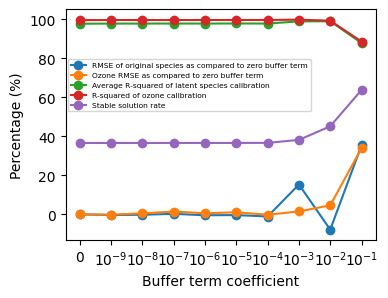

In [16]:
x = range(10)
plt.figure(figsize=(4,3))
plt.plot(x, rmse, 'o-', label='RMSE of original species as compared to zero buffer term')
plt.plot(x, rmse_O3, 'o-', label='Ozone RMSE as compared to zero buffer term')
plt.plot(x, r2_pc, 'o-', label='Average R-squared of latent species calibration')
plt.plot(x, r2_O3, 'o-', label='R-squared of ozone calibration')
plt.plot(x, stable, 'o-', label='Stable solution rate')

plt.legend(loc='upper left', bbox_to_anchor=(-0.005, 0.8), prop={'size': 5.4})
plt.ylabel("Percentage (%)")
plt.xlabel("Buffer term coefficient")
plt.xticks(np.arange(10), ['0', '10$^{-9}$', '10$^{-8}$', '10$^{-7}$', '10$^{-6}$', '10$^{-5}$', '10$^{-4}$', '10$^{-3}$', '10$^{-2}$','10$^{-1}$'])
plt.savefig('figure\\buffer_term.svg', format='svg', dpi=1200, bbox_inches="tight")

In [21]:
# np.save("result\\buffer_coef_tuning.npy", np.stack((rmse, rmse_O3, stable, r2_pc, r2_O3)))